In [30]:
import pandas as pd
import numpy as np
import pulp
import os
import h5py
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from matchms.importing import load_from_mgf
from rdkit import Chem
from rdkit.Chem import DataStructs
from tqdm import tqdm
from myopic_mces.myopic_mces import MCES
import h5py
import massspecgym.utils as utils


from massspecgym.utils import (
    morgan_fp, init_plotting, smiles_to_scaffold,
    train_val_test_split, create_split_file,
    MyopicMCES, MyopicMCESNew
    )

In [2]:
# Load the data from MGF file
file_path = '/Users/macbook/CODE/MS/data/MSn/MSn/20240914_msn_library_pos_all_lib_MSn.mgf'
spectra = list(load_from_mgf(file_path))

In [3]:
# Extract unique SMILES
unique_smiles = set()
for spectrum in spectra:
    if 'smiles' in spectrum.metadata:
        unique_smiles.add(spectrum.metadata['smiles'])

In [4]:
len(unique_smiles)

14008

In [5]:
# Convert unique SMILES to a list
unique_smiles = list(unique_smiles)

In [6]:
unique_smiles = unique_smiles[:100]

In [7]:
# Initialize the MCES computation instance
mces_calculator_new = MyopicMCESNew()

In [7]:
# Compute the MCES distance matrix
# num_smiles = len(unique_smiles)
# dists = np.zeros((num_smiles, num_smiles))

In [13]:
# hdf5_path = '/Users/macbook/CODE/MS/data/MSn/MSn/mces_distances.hdf5'
# 
# # Initialize or load the distance matrix in HDF5 format
# if os.path.exists(hdf5_path):
#     hdf5_file = h5py.File(hdf5_path, 'a')
#     dists = hdf5_file['mces'][:]
# else:
#     hdf5_file = h5py.File(hdf5_path, 'w')
#     dists = np.full((num_smiles, num_smiles), np.inf)  # Initialize with infinity
#     hdf5_file.create_dataset('mces', data=dists)


In [24]:
# Create a DataFrame to keep track of unique SMILES and their indices
smiles_df = pd.DataFrame(unique_smiles, columns=['smiles'])

# Save unique SMILES and indices to CSV for reference
smiles_df_path = '/Users/macbook/CODE/MS/data/MSn/MSn/unique_smiles_small.csv'
# smiles_df.to_csv(smiles_df_path, index=False)


In [14]:
# for i in tqdm(range(num_smiles), desc="Computing MCES distances"):
#     for j in range(i + 1, num_smiles):
#         if np.isinf(dists[i, j]):  # Only compute if not already done
#             dist = mces_calculator_new(unique_smiles[i], unique_smiles[j])
#             dists[i, j] = dist
#             dists[j, i] = dist
#         # Save progress every 1000 calculations
#         if (i * num_smiles + j) % 1000 == 0:
#             hdf5_file['mces'][:] = dists
#             hdf5_file.flush()


Computing MCES distances:   0%|          | 3/14008 [15:30<1207:15:40, 310.33s/it]


KeyboardInterrupt: 

In [ ]:
# hdf5_file['mces'][:] = dists
# hdf5_file.flush()
# hdf5_file.close()
# 
# print("MCES distance computation completed and saved.")

In [9]:
pulp.listSolvers(onlyAvailable=True)

['CPLEX_CMD', 'PULP_CBC_CMD']

# h5py

In [9]:
df = pd.read_csv('/Users/macbook/CODE/MS/data/MSn/MSn/MassSpecGym.tsv', sep='\t')

In [10]:
len(df)

231104

In [11]:
f = h5py.File('/Users/macbook/CODE/MS/data/MSn/MSn/all_smiles_mces.hdf5', 'r')
print(list(f.keys()))
dists = squareform(f['mces'])
dists_smiles = f['mces_smiles_order'][:].astype(str).tolist()
dists.shape, len(dists_smiles)


['mces', 'mces_smiles_order']


((34731, 34731), 34731)

In [13]:
len(dists_smiles)

34731

In [14]:
for s in df['smiles'].unique():
    assert s in dists_smiles

In [16]:
common_smiles = set(unique_smiles) & set(dists_smiles)

# Count how many unique_smiles are in dists_smiles
count = len(common_smiles)

print(f"Number of unique_smiles in dists_smiles: {count}")

Number of unique_smiles in dists_smiles: 62


In [10]:
# Create computation indices for MCES (all pairs, excluding self-comparisons)
computation_indices = []
for i in range(len(unique_smiles)):
    for j in range(i + 1, len(unique_smiles)):
        computation_indices.append([len(computation_indices), i, j])

# Save the input HDF5 file
with h5py.File('/Users/macbook/CODE/MS/data/MSn/MSn/mces_input_small.hdf5', 'w') as f:
    f.create_dataset('smiles', data=np.array(unique_smiles, dtype='S'))
    f.create_dataset('computation_indices', data=np.array(computation_indices, dtype='i'))

After running a script:

python -m myopic_mces.myopic_mces \
    --threshold 15 \
    --solver CPLEX_CMD \
    --solver_no_msg \
    --solver_onethreaded \
    --choose_bound_dynamically \
    --num_jobs 8 \
    --hide_rdkit_warnings \
    --catch_computation_errors \
    --hdf5_mode \
    /Users/macbook/CODE/MS/data/MSn/MSn/mces_input_small.hdf5 \
    /Users/macbook/CODE/MS/data/MSn/MSn/mces_output_small.hdf5


In [43]:
# There should be all smiles not only unique
df = pd.read_csv('/Users/macbook/CODE/MS/data/MSn/MSn/unique_smiles_small.csv', sep='\t')
len(df)

100

In [44]:
f = h5py.File('/Users/macbook/CODE/MS/data/MSn/MSn/mces_input_small.hdf5', 'r')
print(list(f.keys()))
dists = squareform(f['mces'])
dists_smiles = f['smiles'][:].astype(str).tolist()
dists.shape, len(dists_smiles)

['computation_args', 'computation_indices', 'computation_modes', 'computation_times', 'mces', 'smiles']


((100, 100), 100)

In [45]:
for s in df['smiles'].unique():
    assert s in dists_smiles

In [46]:
unique_smiles = df['smiles'].unique()
smiles_mask = np.array([s in unique_smiles for s in dists_smiles])
print(smiles_mask.shape[0], smiles_mask.sum(), len(unique_smiles))

dists = dists[smiles_mask, :][:, smiles_mask]
dists_smiles = np.array(dists_smiles)[smiles_mask]

from scipy.linalg import issymmetric
assert issymmetric(dists)

len(dists_smiles), dists.shape

100 100 100


(100, (100, 100))

## Perform agglomerative clustering using MCES distances

In [47]:
clustering = AgglomerativeClustering(
    metric='precomputed',
    linkage='single',
    distance_threshold=10,
    n_clusters=None
).fit(dists)
clusters = clustering.labels_
pd.Series(clusters).value_counts()

90    1
33    1
42    1
38    1
29    1
     ..
72    1
74    1
71    1
98    1
0     1
Name: count, Length: 100, dtype: int64

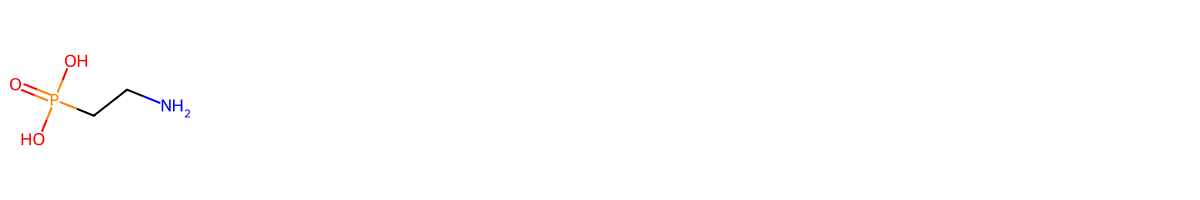

In [48]:
img = utils.show_mols(
    dists_smiles[np.where(clusters == 11)[0]].tolist(),
    smiles_in=True, legends=[], mols_per_row=6, svg=True,
    save_pth='cluster_example.svg'
)
img

## Define train-validation-test split

### Compute metadata stratification groups

# TO DO notebook 5_split

In [50]:
smiles_to_cluster = dict(zip(dists_smiles, clusters))
df['cluster'] = df['smiles'].map(smiles_to_cluster)

# top_k_ces = df['collision_energy'].value_counts().index[:5]
smiles_vc = df['smiles'].value_counts()

# def simple_ce(ce):
#     if pd.isnull(ce):
#         return 'none'
#     if ce in top_k_ces:
#         return str(ce)
#     return 'other'

def simple_smiles_count(smiles):
    c = smiles_vc[smiles]
    if c < 3:
        return '(0, 3)'
    elif c <= 5:
        return '(3, 5]'
    elif c > 100:
        return '(100, inf)'
    return '(5, 100]'

def stratification_group(row):
    return str(simple_smiles_count(row['smiles']))

# def stratification_group(row):
#     return str(row['adduct']) + \
#         str(row['instrument_type']) + \
#         str(simple_ce(row['collision_energy'])) + \
#         str(simple_smiles_count(row['smiles']))

df['stratification_group'] = df.apply(stratification_group, axis=1)
df['stratification_group'].value_counts()

stratification_group
(0, 3)    100
Name: count, dtype: int64

In [51]:
df

,smiles,cluster,stratification_group
0,CCc1cc(=O)oc2c1ccc(OCC(=O)N[C@@H](Cc1c[nH]c3cc...,90,"(0, 3)"
1,CN(C)CCN(Cc1ccc(Cl)cc1)c1ccccn1,81,"(0, 3)"
2,CCn1nnc2c1ncnc2N1CCN(C(=O)c2ccc(Br)o2)CC1,79,"(0, 3)"
3,CC(C)Oc1ccc(CNC(=O)c2cc3c(cc2)Oc2ccccc2C(=O)N3...,61,"(0, 3)"
4,COc1c(CC=C(C)C)c(OC)c2C[C@H](c3c(O)c(CC=C(C)C)...,88,"(0, 3)"
...,...,...,...
95,CC(C)NC[C@H](O)COc1ccc(CCOCC2CC2)cc1,5,"(0, 3)"
96,CC1CCCCN1C(=O)c1ccc(S(=O)(=O)N2CCCCC2C)cc1,2,"(0, 3)"
97,CCOc1c2cccnc2c(OCC)c2c1C(=O)N(c1c(C)cc(CS(=O)(...,4,"(0, 3)"
98,C[C@H]1O[C@@H](O[C@H]2CC[C@@]3(C)[C@@H](CC[C@]...,1,"(0, 3)"


In [41]:
# X = df['identifier'].values
X = df['smiles'].values
y = df['stratification_group'].values
groups = df['cluster'].values
sgkf = StratifiedGroupKFold(n_splits=3)
sgkf_split = sgkf.split(X, y, groups)
folds = []
for i, (train_index, test_index) in enumerate(sgkf_split):
    print(f'{len(test_index)} ({len(test_index) / len(X) * 100:.2f} %)')
    folds.append(X[test_index])

34 (34.00 %)
33 (33.00 %)
33 (33.00 %)


In [53]:
folds_map = {}
for i, fold in enumerate(folds):
    for identifier in fold:
        folds_map[identifier] = ['train', 'val', 'test'][i]
df['fold'] = df['smiles'].map(folds_map)

def fold_composition(df_q, percentage=True):
    unique_counts = df_q.groupby(['fold']).agg({'smiles': 'nunique', 'cluster': 'nunique'})
    if not percentage:
        res = unique_counts
    else:
        total_counts = df_q.agg({'smiles': 'nunique', 'cluster': 'nunique'})
        percentage_counts = (unique_counts / total_counts) * 100
        res = percentage_counts.round(2)
    return res[[ 'smiles', 'cluster']].loc[['train', 'val', 'test']]
for percentage in [False, True]:
    print(f'Full dataset (percentage={percentage})')
    display(fold_composition(df, percentage=percentage))
    print(f'All metadata available (percentage={percentage})')
    display(fold_composition(df.dropna(), percentage=percentage))

Full dataset (percentage=False)


,smiles,cluster
fold,,
train,34,34
val,33,33
test,33,33


All metadata available (percentage=False)


,smiles,cluster
fold,,
train,34,34
val,33,33
test,33,33


Full dataset (percentage=True)


,smiles,cluster
fold,,
train,34.0,34.0
val,33.0,33.0
test,33.0,33.0


All metadata available (percentage=True)


,smiles,cluster
fold,,
train,34.0,34.0
val,33.0,33.0
test,33.0,33.0


## Additionally move random validation and test clusters to the train fold


In [56]:
df_split = df.copy()
for f in ['val', 'test']:
    df_fold = df[df['fold'] == f].copy()
    rand_fold_clusters = df_fold['cluster'].drop_duplicates().sample(n=10, random_state=42).values
    df_split.loc[df_split['cluster'].isin(rand_fold_clusters), 'fold'] = 'train'

for percentage in [False, True]:
    print(f'Full dataset (percentage={percentage})')
    display(fold_composition(df_split, percentage=percentage))
    print(f'All metadata available (percentage={percentage})')
    display(fold_composition(df_split.dropna(), percentage=percentage))

Full dataset (percentage=False)


,smiles,cluster
fold,,
train,54,54
val,23,23
test,23,23


All metadata available (percentage=False)


,smiles,cluster
fold,,
train,54,54
val,23,23
test,23,23


Full dataset (percentage=True)


,smiles,cluster
fold,,
train,54.0,54.0
val,23.0,23.0
test,23.0,23.0


All metadata available (percentage=True)


,smiles,cluster
fold,,
train,54.0,54.0
val,23.0,23.0
test,23.0,23.0


## Cluster Sizes


In [57]:
df.drop_duplicates(subset=['inchikey']).groupby(['cluster', 'fold']).agg({'inchikey': 'count'}).sort_values(by='inchikey', ascending=False)


KeyError: Index(['inchikey'], dtype='object')

In [ ]:


# Prepare MCES or alternative distance matrix for clustering
# Here we create a placeholder distance matrix with random values
# Replace with your distance calculation logic
num_smiles = len(unique_smiles)
dists = np.random.rand(num_smiles, num_smiles)
dists = (dists + dists.T) / 2  # Symmetrize the matrix to ensure it's valid
np.fill_diagonal(dists, 0)  # Set diagonal to zero for self-distance

# Check if the matrix is symmetric
from scipy.linalg import issymmetric
assert issymmetric(dists)

# Perform Agglomerative Clustering using the precomputed distances
clustering = AgglomerativeClustering(
    metric='precomputed',
    linkage='single',
    distance_threshold=10,
    n_clusters=None
).fit(dists)

# Get cluster labels
clusters = clustering.labels_

# Create a DataFrame for the SMILES and their clusters
df = pd.DataFrame({'smiles': unique_smiles, 'cluster': clusters})

# Define a placeholder for collision energies and other metadata for stratification
# Here, we add mock data; replace with your actual data extraction logic
df['collision_energy'] = np.random.choice(['10.0', '20.0', '30.0', 'other'], size=len(df))
df['instrument_type'] = np.random.choice(['ITFT', 'QFT', 'Other'], size=len(df))
df['adduct'] = np.random.choice(['[M+H]+', '[M+Na]+'], size=len(df))

# Define stratification groups based on the metadata
def simple_ce(ce):
    if ce in ['10.0', '20.0', '30.0']:
        return ce
    return 'other'

def stratification_group(row):
    return str(row['adduct']) + str(row['instrument_type']) + str(simple_ce(row['collision_energy']))

df['stratification_group'] = df.apply(stratification_group, axis=1)

# Perform the train-validation-test split
X = df.index.values  # Use indices as identifiers
y = df['stratification_group'].values
groups = df['cluster'].values

sgkf = StratifiedGroupKFold(n_splits=3)
sgkf_split = sgkf.split(X, y, groups)

# Assign the splits to the DataFrame
folds_map = {}
for i, (train_index, test_index) in enumerate(sgkf_split):
    fold_name = ['train', 'val', 'test'][i]
    for idx in test_index:
        folds_map[idx] = fold_name

df['fold'] = df.index.map(folds_map)

# Show the split composition
def fold_composition(df_q, percentage=True):
    unique_counts = df_q.groupby(['fold']).agg({'smiles': 'nunique'})
    if not percentage:
        res = unique_counts
    else:
        total_counts = df_q.agg({'smiles': 'nunique'})
        percentage_counts = (unique_counts / total_counts) * 100
        res = percentage_counts.round(2)
    return res

print('Fold composition:')
print(fold_composition(df))

# Save the split data to a file
df.to_csv('/Users/macbook/CODE/MS/data/MSn/MSn/MassSpecGym_split.tsv', sep='\t', index=False)